In [1]:
### DEFINING WEIGHTED AVERAGE

def simple_weighted_average(ser_to_manage, ser_weights):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd           
    ### Clearing and docking vectors:
    ser_to_manage_filtered = ser_to_manage.dropna()
    ser_weights_filtered = ser_weights.dropna()
    index_filtered = ser_to_manage_filtered.index.intersection(ser_weights_filtered.index)
    ser_to_manage_filtered = ser_to_manage_filtered[index_filtered]
    ser_weights_filtered = ser_weights_filtered[index_filtered]
    ### Result calculating:
    if (ser_to_manage_filtered.count() > 0):
        num_result = ser_to_manage_filtered.dot(ser_weights_filtered) / sum(ser_weights_filtered)
    else:
        num_result = 0
    
    return num_result

In [2]:
### DEFINING MULTI-STEP STANDARTIZATION

def simple_standartize(ser_to_manage, ser_weights, arr_truncates, reuse_outliers = False, center_result = True, full_result = False):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd      
    ### Arrays of iterations properties:
    arr_mean = []
    arr_std = []
    ### Workhorse and resulting data vectors initialising:
    ser_data_full = ser_to_manage.copy()
    ser_data_full = ser_data_full.dropna()
    ser_data_iter = ser_to_manage.dropna().copy() 
    ser_weights_iter = ser_weights.copy()
    ser_data_full.replace(ser_data_full.values, 0, inplace = True)    
    ### Looping by boundaries array:
    for num_bound_iter in arr_truncates:
        ### Clearing and docking vectors:        
        index_iter = ser_data_iter.index.intersection(ser_weights_iter.index)
        ser_data_iter = ser_data_iter[index_iter]
        ser_weights_iter = ser_weights_iter[index_iter] 
        ### Properties calculating and saving:
        num_mean_iter = simple_weighted_average(ser_data_iter, ser_weights_iter)
        num_std_iter = ser_data_iter.std()
        arr_mean.append(num_mean_iter)
        arr_std.append(num_std_iter)
        ser_data_iter = (ser_data_iter - num_mean_iter) / num_std_iter       
        ### Standartizing:
        ser_data_iter[ser_data_iter.abs() >= num_bound_iter] = np.sign(ser_data_iter) * num_bound_iter 
        if not (reuse_outliers):
            ### Saving to result and excluding from further calculations truncated values:     
            ser_data_full.where(ser_data_iter.abs() < num_bound_iter, np.sign(ser_data_iter) * num_bound_iter, inplace = True)
            ser_data_iter = ser_data_iter[ser_data_iter.abs() < num_bound_iter]           
    ### Aggregating result:
    if (reuse_outliers):
        ser_data_full = ser_data_iter
    else:     
        ser_data_full[ser_data_iter.index] = ser_data_iter
    ### Centering result:
    if (center_result):      
        ser_result = ser_data_full - simple_weighted_average(ser_data_full, ser_weights) 
    else:
        ser_result = ser_data_full    
    ### Result output:
    if (full_result):
        return (ser_result, arr_mean, arr_std)
    else:
        return ser_result

In [3]:
### DEFINING EXPONENTIAL WEIGHT

def get_exp_weight_single(halflife_len = 3, num_element = 0):
    ### Importing standard modules:    
    import numpy as np
    import pandas as pd
    import math     

    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    
    return num_weight

In [2]:
### INITIALIZATION

### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
### Declaring global constants & variables: 
path_cds_data_hdf = 'Data_Files/Source_Files/CDS_Data.h5' ### Path to CDS data
key_cds_mcap = 'cds_mcap' ### CDS with mcaps object
key_cds_corr = 'cds_corr' ### CDS correlations object
path_cds_result_hdf = 'Data_Files/Source_Files/CDS_Result.h5' ### Path to blended CDS index
key_cds_result = 'cds_blended' ### blended CDS object
path_cds_ma_hdf = 'Data_Files/Source_Files/CDS_MA.h5' ### Path to CDS sources MA
key_cds_ma = 'cds_ma' ### CDS Sources MA object
path_cds_corr_by_market_hdf = 'Data_Files/Source_Files/CDS_Corr_by_Market.h5' ### Path to CDS correlation for by market standartized values
key_cds_corr = 'cds_corr' ### CDS correlation for by market standartized values object 
num_ffill_limit = 44 ### Forward filling distance
arr_standart_truncate = [2.5, 2.0] ### Standartization boundaries
num_corr_min_countries = 5 ### Mimimal countries number for cross-sectional correlation between CBIN and CMAN
num_month_smooth = 3 ### Start CMAN month period for smoothing
num_smooth_roll_max = 10 ### Max window length for smoothing by moving average
num_smooth_roll_min = num_smooth_roll_max ### Min window length for smoothing by moving average
num_cds_ma_window = 5 ### Max window length for MA by datasource/country calculation
num_cds_ma_min = num_cds_ma_window ### Min window length for MA by datasource/country calculation
arr_ma_weight_line = list(range(1, (num_cds_ma_window + 1))) ### Linear weights for MA by datasource/country calculation
num_expo_halflife = num_ffill_limit // 2 ### Half-life period by datasource/country data freshness for cross-sectional weights
float_zero_tolerance = 0.001 ### For float comparision with 0
All = slice(None) ### No-slice for MultiIndex level for usinge in loc method
tup_plt_size = (20, 5) ### Plot sizes
### CDS with ISON and market caps reading and earlier calculated data:
df_cds_raw = pd.read_hdf(path_cds_data_hdf, key_cds_mcap)
df_cds_ma = pd.read_hdf(path_cds_ma_hdf, key_cds_ma)
df_cds_corr_full = pd.read_hdf(path_cds_data_hdf, key_cds_corr).droplevel(0, axis = 1)
df_cds_corr_within = pd.read_hdf(path_cds_corr_by_market_hdf, key_cds_corr).droplevel(0, axis = 1)
ser_cds_res = pd.read_hdf(path_cds_result_hdf, key_cds_result)

In [ ]:
### CDS COVERAGE

### Declaring global constants & variables: 
arr_cds_source = ['CBIN', 'CMAN']
arr_market = [All, ['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]
arr_market_str = ['ANY REGION', 'ISON', 'DM only', 'EM only', 'FM only']
arr_period = [999, 24, 12]
arr_period_str = ['ALL DATES', 'LAST TWO YEARS', 'LAST YEAR']
### Testing values:
arr_market = [['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]
arr_market_str = ['ISON', 'DM only', 'EM only', 'FM only']
arr_period = [999]
arr_period_str = ['ALL DATES'] 
### Looping periods:
for iter_period_num, iter_period in enumerate(arr_period):
    ### Looping markets:
    for iter_market_num, iter_market in enumerate(arr_market):
        ### Defining index:
        iter_prefix = arr_period_str[iter_period_num] + ' : ' + arr_market_str[iter_market_num]
        ### Selecting appropriate data set:
        iter_last_date = df_cds_raw.index.get_level_values(0).max()
        iter_range = pd.date_range(iter_last_date - pd.offsets.BMonthEnd(iter_period) + pd.offsets.BDay(), iter_last_date, freq = 'B')
        df_iter_cds = df_cds_raw.loc[(iter_range, All, iter_market), :]
        ### Looping sources:
        dict_coverage = {}
        ### Coverage calculating:
        for iter_source in arr_cds_source:
            ser_iter_cds = df_iter_cds[iter_source]
            ser_iter_coverage = ser_iter_cds.groupby('Date').apply(lambda iter_group: iter_group.count() / len(iter_group.index))    
            dict_coverage[iter_source] = ser_iter_coverage
        ### Coverage plotting:
        df_iter_coverage = pd.concat(dict_coverage, axis = 1)
        plt_coverage = df_iter_coverage.plot(figsize = tup_plt_size, title = iter_prefix)
        plt_coverage.set_ylim(0.0, 1.0)
        plt.show()

In [66]:
### CORRELATION CALCULATING

### Defining standartized correlation function:
def standartized_corr(ser_iter_group, arr_standart_truncate, flag_within, num_corr_min_countries):
    ### Standartizing bydate-vectors for correlation calculating:
    if flag_within:
    ### Within markets standartising:
        dict_iter_standartized = {}
        for iter_source in ['CBIN', 'CMAN']:
        ### Source looping:
            ser_iter_source = ser_iter_group[iter_source]
            dict_iter_grouped = ser_iter_source.groupby('Market').groups         
            dict_iter_market = {}
            for iter_market in dict_iter_grouped:
            ### Market looping:
                ser_iter_market = ser_iter_source[dict_iter_grouped[iter_market]]
                ser_iter_weight = pd.Series(1, index = ser_iter_market.index)
                dict_iter_market[iter_market] = simple_standartize(ser_iter_market, ser_iter_weight, arr_standart_truncate)
            ### Source markets merging:
            dict_iter_standartized[iter_source] = pd.concat(dict_iter_market)
    else:
    ### Full ISON standartising:
        dict_iter_standartized = {}
        for iter_source in ['CBIN', 'CMAN']:
            dict_iter_standartized[iter_source] = simple_standartize(ser_iter_group[iter_source], ser_iter_group['Weight'], arr_standart_truncate)
    ### Results output:
    num_iter = dict_iter_standartized['CBIN'].corr(dict_iter_standartized['CMAN'], min_periods = num_corr_min_countries)
    return num_iter 
### Declaring global constants & variables: 
arr_cds_source = ['CBIN', 'CMAN']
arr_market = [All, ['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]
arr_market_str = ['ANY REGION', 'ISON', 'DM only', 'EM only', 'FM only']
arr_period = [999, 24, 12]
arr_period_str = ['ALL DATES', 'LAST TWO YEARS', 'LAST YEAR']
### Testing values:
arr_market = [['DM', 'EM', 'FM'], ['DM'], ['EM'], ['FM']]
arr_market_str = ['ISON', 'DM only', 'EM only', 'FM only']
arr_period = [999]
arr_period_str = ['ALL DATES'] 
### Gaps partial filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))
### Equal weights adding:
df_cds_ffill['Weight'] = 1
### Looping periods:
dict_corr = {}
for iter_period_num, iter_period in enumerate(arr_period):
    ### Looping markets:
    dict_iter_period = {}
    for iter_market_num, iter_market in enumerate(arr_market):
        ### Defining index:
        iter_prefix = arr_period_str[iter_period_num]
        ### Selecting appropriate data set:
        iter_last_date = df_cds_ffill.index.get_level_values(0).max()
        iter_range = pd.date_range(iter_last_date - pd.offsets.BMonthEnd(iter_period) + pd.offsets.BDay(), iter_last_date, freq = 'B')
        df_iter_cds = df_cds_ffill.loc[(iter_range, All, iter_market), :]
        ### Two-step standartized correlation:
        dict_iter_period[arr_market_str[iter_market_num]] = df_iter_cds.groupby('Date').apply(standartized_corr, arr_standart_truncate, True, num_corr_min_countries)
    ### Results aggregating:
    df_iter_corr = pd.concat(dict_iter_period, axis = 1)
    dict_corr[arr_period_str[iter_period_num]] = df_iter_corr
df_cds_corr = pd.concat(dict_corr, axis = 1)
### Correlation results saving:
#df_cds_corr.to_hdf(path_cds_corr_by_market_hdf, key_cds_corr, method = 'w')

In [ ]:
### TESTER FULL STANDARTIZED CORRELATION VISUALIZATION

### Declaring global constants & variables: 
arr_period = [999, 60, 36, 12]
arr_period_str = ['ALL DATES', 'LAST FIVE YEARS', 'LAST THREE YEARS', 'LAST YEAR']
### Visualization process:
for iter_period_num, iter_period in enumerate(arr_period):
    ### Looping periods:
    iter_first_date = df_cds_corr_full.dropna(how = 'all').index.get_level_values(0).min()
    iter_last_date = df_cds_corr_full.index.get_level_values(0).max()
    iter_range = pd.date_range(max(iter_first_date, iter_last_date - pd.offsets.BMonthEnd(iter_period) + pd.offsets.BDay()), iter_last_date, freq = 'B')
    df_iter_cds = df_cds_corr_full.loc[(iter_range), :]
    print(arr_period_str[iter_period_num], ':\n', df_iter_cds.mean(axis = 0))
    plt_corr = df_iter_cds.plot(figsize = tup_plt_size, title = arr_period_str[iter_period_num])
    plt_corr.set_ylim(0.75, 1.05)
    plt.show()   

ALL DATES :
 ISON       0.938657
DM only    0.940324
EM only    0.974332
FM only    0.984058
dtype: float64


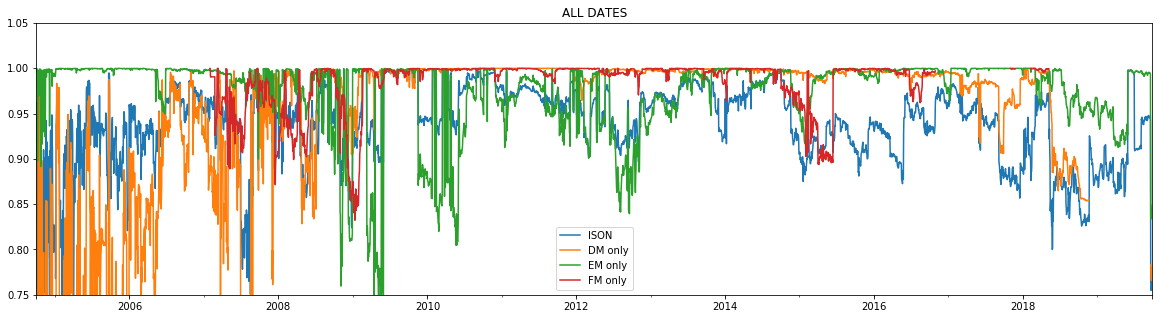

LAST FIVE YEARS :
 ISON       0.919186
DM only    0.974224
EM only    0.984612
FM only    0.980185
dtype: float64


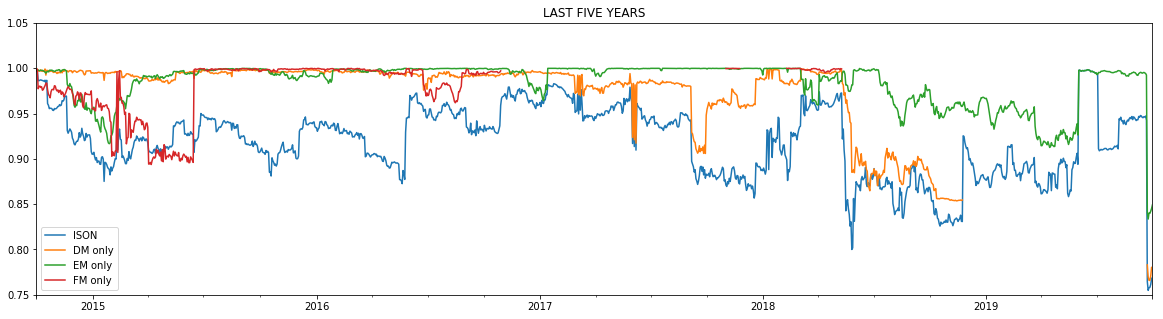

LAST THREE YEARS :
 ISON       0.913678
DM only    0.955522
EM only    0.980839
FM only    0.998284
dtype: float64


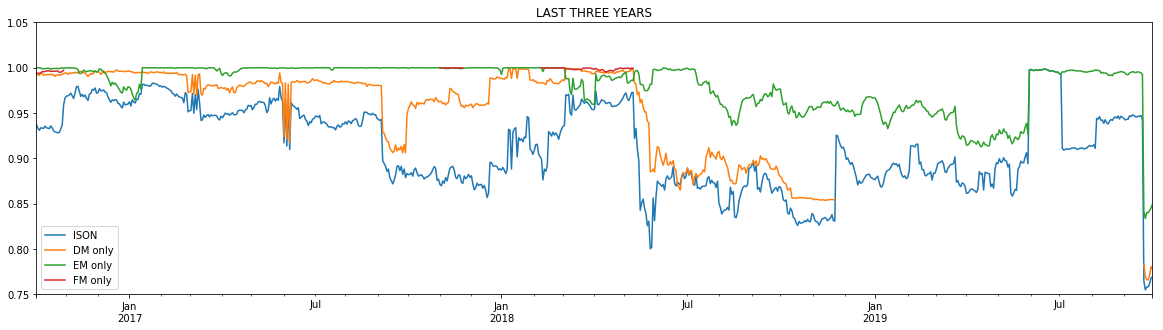

LAST YEAR :
 ISON       0.894684
DM only    0.845615
EM only    0.957725
FM only         NaN
dtype: float64


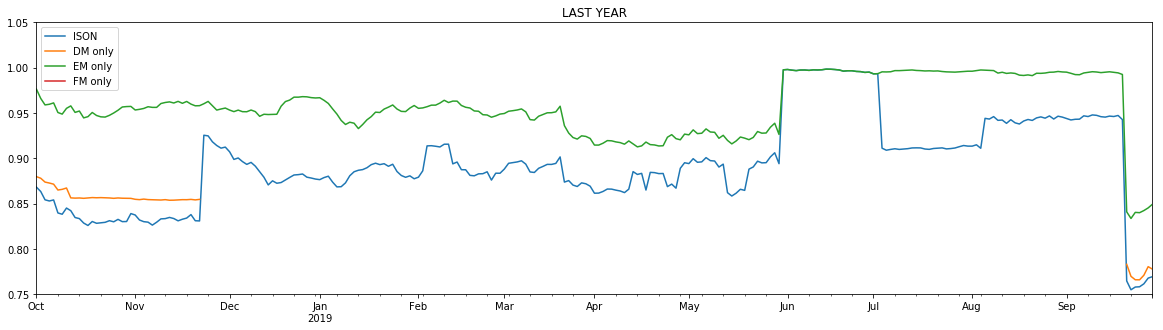

In [68]:
### TESTER WITHIN MARKET STANDARTIZED CORRELATION VISUALIZATION

### Declaring global constants & variables: 
arr_period = [999, 60, 36, 12]
arr_period_str = ['ALL DATES', 'LAST FIVE YEARS', 'LAST THREE YEARS', 'LAST YEAR']
### Visualization process:
for iter_period_num, iter_period in enumerate(arr_period):
    ### Looping periods:
    iter_first_date = df_cds_corr_within.dropna(how = 'all').index.get_level_values(0).min()
    iter_last_date = df_cds_corr_within.index.get_level_values(0).max()
    iter_range = pd.date_range(max(iter_first_date, iter_last_date - pd.offsets.BMonthEnd(iter_period) + pd.offsets.BDay()), iter_last_date, freq = 'B')
    df_iter_cds = df_cds_corr_within.loc[(iter_range), :]
    print(arr_period_str[iter_period_num], ':\n', df_iter_cds.mean(axis = 0))
    plt_corr = df_iter_cds.plot(figsize = tup_plt_size, title = arr_period_str[iter_period_num])
    plt_corr.set_ylim(0.75, 1.05)
    plt.show()  

In [79]:
### TESTER CORRELATION WITH/WITHOUT STANDARTIZATION ('2007-10-18' / ISON)

### Gaps partial filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))

df_corr_test_ffill = df_cds_ffill.loc[('2007-10-18', All, ['DM', 'EM', 'FM']), ['CBIN', 'CMAN']]
df_corr_test_ffill['Weight'] = 1
ser_cbin_test_ffill = df_corr_test_ffill['CBIN']
ser_cman_test_ffill = df_corr_test_ffill['CMAN']
df_corr_test_ffill.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2007_10_18_Ffill.xlsx')
print('Forward filled data correlation', '(2007-10-18)', ':', round(ser_cbin_test_ffill.corr(ser_cman_test_ffill), 5))
df_corr_test_std = pd.DataFrame()
ser_cbin_test_std = simple_standartize(df_corr_test_ffill['CBIN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
ser_cman_test_std = simple_standartize(df_corr_test_ffill['CMAN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
df_corr_test_std = pd.concat([ser_cbin_test_std, ser_cman_test_std], axis = 1)
print('Standartized data correlation', '(2007-10-18)', ':', round(ser_cbin_test_std.corr(ser_cman_test_std), 5))
df_corr_test_std.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2007_10_18_2StepStd.xlsx')

Forward filled data correlation (2007-10-18) : 0.98192
Standartized data correlation (2007-10-18) : 0.99343


In [77]:
### TESTER CORRELATION WITH/WITHOUT STANDARTIZATION ('2011-05-10' / ISON)

### Gaps partial filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))

df_corr_test_ffill = df_cds_ffill.loc[('2011-05-10', All, ['DM', 'EM', 'FM']), ['CBIN', 'CMAN']]
df_corr_test_ffill['Weight'] = 1
ser_cbin_test_ffill = df_corr_test_ffill['CBIN']
ser_cman_test_ffill = df_corr_test_ffill['CMAN']
df_corr_test_ffill.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2011_05_10_Ffill.xlsx')
print('Forward filled data correlation', '(2011-05-10)', ':', round(ser_cbin_test_ffill.corr(ser_cman_test_ffill), 5))
df_corr_test_std = pd.DataFrame()
ser_cbin_test_std = simple_standartize(df_corr_test_ffill['CBIN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
ser_cman_test_std = simple_standartize(df_corr_test_ffill['CMAN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
df_corr_test_std = pd.concat([ser_cbin_test_std, ser_cman_test_std], axis = 1)
print('Standartized data correlation', '(2011-05-10)', ':', round(ser_cbin_test_std.corr(ser_cman_test_std), 5))
df_corr_test_std.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2011_05_10_2StepStd.xlsx')

Forward filled data correlation (2011-05-10) : 0.99973
Standartized data correlation (2011-05-10) : 0.99998


In [78]:
### TESTER CORRELATION WITH/WITHOUT STANDARTIZATION ('2015-07-03' / ISON)

### Gaps partial filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))

df_corr_test_ffill = df_cds_ffill.loc[('2015-07-03', All, ['DM', 'EM', 'FM']), ['CBIN', 'CMAN']]
df_corr_test_ffill['Weight'] = 1
ser_cbin_test_ffill = df_corr_test_ffill['CBIN']
ser_cman_test_ffill = df_corr_test_ffill['CMAN']
df_corr_test_ffill.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2015_07_03_Ffill.xlsx')
print('Forward filled data correlation', '(2015-07-03)', ':', round(ser_cbin_test_ffill.corr(ser_cman_test_ffill), 5))
df_corr_test_std = pd.DataFrame()
ser_cbin_test_std = simple_standartize(df_corr_test_ffill['CBIN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
ser_cman_test_std = simple_standartize(df_corr_test_ffill['CMAN'], df_corr_test_ffill['Weight'], arr_standart_truncate)
df_corr_test_std = pd.concat([ser_cbin_test_std, ser_cman_test_std], axis = 1)
print('Standartized data correlation', '(2015-07-03)', ':', round(ser_cbin_test_std.corr(ser_cman_test_std), 5))
df_corr_test_std.to_excel('Data_Files/Test_Files/Test_CDS_Corr_ISON_2015_07_03_2StepStd.xlsx')

Forward filled data correlation (2015-07-03) : 0.99505
Standartized data correlation (2015-07-03) : 0.78083


In [ ]:
### TESTER COUNTRIES VISUALIZATION

flag_CBIN = False
### Gaps partial filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))
### Countries visualizing for CBIN excluding decision:
for iter_country in df_cds_ffill.index.get_level_values(1).unique():
    df_iter_cds = df_cds_ffill.loc[(All, iter_country, All), All].droplevel([1, 2])
    if (len(df_iter_cds.dropna(how = 'all').index) > 0):
        ### CBIN excluding decision:
        if (flag_CBIN):
            iter_first_date = df_iter_cds.dropna(how = 'all').index.get_level_values(0).min()
            iter_last_date = df_iter_cds.index.get_level_values(0).max()        
            iter_range = pd.date_range(iter_first_date, iter_last_date, freq = 'B')
            ### Plotting:
            df_iter_cds = df_iter_cds.loc[(iter_range), :]
            df_iter_cds.plot(figsize = tup_plt_size, title = iter_country)            
        ### First-month CMAN excluding decision:
        else:
            iter_first_date = df_iter_cds['CMAN'].dropna().index.get_level_values(0).min()
            iter_range = pd.date_range(iter_first_date, iter_first_date + pd.offsets.BMonthEnd(3), freq = 'B')
            ### Plotting:
            df_iter_cds = df_iter_cds.loc[(iter_range), :]
            if ((df_iter_cds['CMAN'] - df_iter_cds['CMAN'].mean()).abs().max() / df_iter_cds['CMAN'].mean() > 0.5):
                df_iter_cds['CMAN_rolled'] = df_iter_cds['CMAN'].rolling(10, 3).mean()
                df_iter_cds.plot(figsize = tup_plt_size, title = iter_country)

In [5]:
### RAW DATA MODIFYING: CMAN SMOOTHING

### Definition of long moving average function for first months of CMAN indexing:
def cman_smoothing(iter_group, num_month_smooth, num_smooth_roll_max, num_smooth_roll_min):
    if (len(iter_group['CMAN'].dropna().index) > 0):
        All = slice(None)
        iter_first_date = iter_group['CMAN'].dropna().index.get_level_values(0).min()
        iter_range = pd.date_range(iter_first_date, iter_first_date + pd.offsets.BMonthEnd(num_month_smooth), freq = 'B')
        iter_start = iter_group.loc[(iter_range, All, All), 'CMAN']
        iter_group.loc[(iter_range, All, All), 'CMAN'] = iter_start.rolling(num_smooth_roll_max, num_smooth_roll_min).mean()
    return iter_group
### Forward filling:
df_cds_ffill = df_cds_raw[['CBIN', 'CMAN']].groupby('Country').apply(lambda iter_group: iter_group.fillna(method = 'ffill', limit = num_ffill_limit))
### First CMAN indexes smoothing:
df_cds_smooth = df_cds_ffill[['CBIN', 'CMAN']].groupby('Country').apply(cman_smoothing, num_month_smooth, num_smooth_roll_max, num_smooth_roll_min)

In [ ]:
### TESTER FOR SMOOTHING:

df_cds_ffill['CMAN_rolled'] = df_cds_smooth['CMAN']
for iter_country in df_cds_ffill.index.get_level_values(1).unique():
    df_iter_cds = df_cds_ffill.loc[(All, iter_country, All), All].droplevel([1, 2])
    if (len(df_iter_cds.dropna().index) > 0):
        iter_first_date = df_iter_cds['CMAN'].dropna().index.get_level_values(0).min()
        iter_range = pd.date_range(iter_first_date, iter_first_date + pd.offsets.BMonthEnd(num_month_smooth + 1), freq = 'B')
        ### Plotting:
        df_iter_cds = df_iter_cds.loc[(iter_range), :]
        df_iter_cds[['CMAN', 'CMAN_rolled']].plot(figsize = tup_plt_size, title = iter_country)

In [6]:
### RAW DATA MODIFYING: SECOND CDS INDEX BACKFILL

### Definition of distances calulation function for NaN values from non-NaN values for future backfilling from other CDS source:
def back_na_distance(iter_group, num_cds_ma_window):
    iter_result = iter_group[::-1].groupby(iter_group[::-1].notna().cumsum()).cumcount()[::-1]   
    if (np.isnan(iter_group.iloc[-1]) & iter_group.count() > 0):
        idx_first_notna = iter_group.index.get_loc(iter_group[iter_group.notna()].index[-1])
        iter_result.iloc[(idx_first_notna + 1) : ] = iter_result.iloc[(idx_first_notna + 1) : ] + num_cds_ma_window
    return iter_result
### Distances distribution for future backfilling:
df_cds_bfill = df_cds_smooth.copy()
df_cds_bfill.columns = df_cds_bfill.columns + '_smooth'
for iter_cds in df_cds_smooth.columns:
    df_cds_bfill[iter_cds + '_distance'] = df_cds_bfill[iter_cds + '_smooth'].groupby('Country').apply(back_na_distance, num_cds_ma_window)
### Backfilling from other index for future moving average:
for iter_cds in df_cds_smooth.columns:
    df_cds_bfill[iter_cds + '_backfill'] = df_cds_bfill[iter_cds + '_smooth']
df_cds_bfill.loc[((df_cds_bfill['CBIN_distance'] > 0) & (df_cds_bfill['CBIN_distance'] < num_cds_ma_window)), 'CBIN_backfill'] = df_cds_bfill['CMAN_smooth']  
df_cds_bfill.loc[((df_cds_bfill['CMAN_distance'] > 0) & (df_cds_bfill['CMAN_distance'] < num_cds_ma_window)), 'CMAN_backfill'] = df_cds_bfill['CBIN_smooth']  

In [ ]:
### RAW DATA MODIFYING: MOVING AVERAGE CALCULATION

def double_weighted_mean(ser_iter_roll, arr_ma_weight_line):
    ### Constant series checking:
    if (abs(ser_iter_roll.std()) < float_zero_tolerance):   
        ser_iter_weight_z = pd.Series(1, index = ser_iter_roll.index)
    else:
    ### Z-score-like weight generating:
        ser_iter_weight_z = ((ser_iter_roll - ser_iter_roll.median()) / ser_iter_roll.std()).abs()
    ### Zero Z-score-like values replacing:
    ser_iter_weight_z.loc[ser_iter_weight_z == 0] = ser_iter_weight_z.loc[ser_iter_weight_z != 0].min() / 2
    ### Full wegiht calculating:
    ser_iter_full_weight = arr_ma_weight_line / ser_iter_weight_z 
    ser_iter_full_weight = ser_iter_full_weight / ser_iter_full_weight.sum()
    ### Rolling result:
    num_result = round((ser_iter_roll * ser_iter_full_weight).sum(), 3)       
    return num_result
### Definition of rolling mean function for country level:
def ma_rolled(iter_group, num_cds_ma_window):
    return iter_group.rolling(window = num_cds_ma_window, min_periods = num_cds_ma_min).apply(double_weighted_mean, raw = False, args = (arr_ma_weight_line, ))
### Moving average rolling:
df_cds_ma_full = df_cds_bfill.copy()
for iter_cds in df_cds_smooth.columns:
    ser_iter_ma_rolled = df_cds_ma_full[iter_cds + '_backfill'].groupby('Country').apply(ma_rolled, num_cds_ma_window)
    ### Not to save backfill origin values:
    ser_iter_ma_rolled.loc[df_cds_ffill[iter_cds].isna() & ser_iter_ma_rolled.notna()] = np.NaN
    ### Saving results:
    ser_iter_ma_rolled.name = iter_cds + '_ma'
    df_cds_ma_full = df_cds_ma_full.join(ser_iter_ma_rolled)
### Selecting MA only data:
df_cds_ma = df_cds_ma_full[['CBIN_ma', 'CMAN_ma']]
df_cds_ma.columns = df_cds_ma.columns.str.rstrip('_ma')

In [9]:
### TESTER FOR MODIFYING STEPS

#df_cds_ma_full.loc[(All, 'BE', All), :].to_excel('Data_Files/Test_Files/Test_CDS_MA.xlsx')
#df_cds_ffill.reset_index('Market', drop = True).unstack('Country').swaplevel(axis = 1).sort_index(axis = 1)\
#.to_excel('Data_Files/Test_Files/CDS_Table_01_Ffill.xlsx')
#df_cds_smooth.reset_index('Market', drop = True).unstack('Country').swaplevel(axis = 1).sort_index(axis = 1)\
#.to_excel('Data_Files/Test_Files/CDS_Table_02_Smooth.xlsx')
#df_cds_bfill[['CBIN_backfill', 'CMAN_backfill']].reset_index('Market', drop = True).unstack('Country').swaplevel(axis = 1).sort_index(axis = 1)\
#.to_excel('Data_Files/Test_Files/CDS_Table_03_Bfill.xlsx')
#df_cds_ma.reset_index('Market', drop = True).unstack('Country').swaplevel(axis = 1).sort_index(axis = 1)\
#.to_excel('Data_Files/Test_Files/CDS_Table_04_MA.xlsx')

In [ ]:
### TESTER FOR MODIFYING STEPS

print(df_cds_raw[['CBIN', 'CMAN']].count())
print(df_cds_ffill[['CBIN', 'CMAN']].count())
print(df_cds_ma[['CBIN', 'CMAN']].count())
print(df_cds_ffill['CBIN'].loc[df_cds_ma['CBIN'].isna()].dropna())
print(df_cds_ffill['CMAN'].loc[df_cds_ma['CMAN'].isna()].dropna())
print(df_cds_ma['CBIN'].loc[df_cds_ffill['CBIN'].isna()].dropna().count())
print(df_cds_ma['CMAN'].loc[df_cds_ffill['CMAN'].isna()].dropna().count())
df_cds_ma.to_hdf(path_cds_ma_hdf, key_cds_ma, method = 'w')

In [40]:
### WEIGHTS FOR BLENDING CALCULATING

### Definition of constant periods calulation function:
def freshness_weights(iter_group):
    arr_cds = ['CBIN', 'CMAN']
    iter_result = iter_group.copy()
    ### CDS sources looping:
    for iter_cds in arr_cds:
        ser_iter_cds = iter_group[iter_cds]    
        ser_iter_period = ser_iter_cds.groupby((ser_iter_cds != ser_iter_cds.shift()).cumsum()).cumcount() + 1
        ### Not forward filled, but raw repeats changing:
        ser_iter_period.loc[df_cds_raw[iter_cds].notna()] = 1       
        ser_iter_period.name = iter_cds + '_period'
        ### Linear weights calculating:
        ser_iter_linear_weight = 1 / ser_iter_period
        ser_iter_linear_weight.loc[ser_iter_cds.isna()] = 0
        ser_iter_linear_weight.name = iter_cds + '_l_weight'
        ### Expo weights calculation:
        ser_iter_expo_weight = get_exp_weight_single(num_expo_halflife, ser_iter_period - 1)
        ser_iter_expo_weight.loc[df_cds_ma[iter_cds].isna()] = 0
        ser_iter_expo_weight.name = iter_cds + '_e_weight'        
        ### Results fixing:
        iter_result = iter_result.join([ser_iter_period, ser_iter_linear_weight, ser_iter_expo_weight])        
    return iter_result
### Freshness period adding:
df_cds_weight_full = df_cds_ffill.groupby('Country').apply(freshness_weights)

In [ ]:
### TESTER WEIGHTS CONTROL

df_cds_weight_expo = df_cds_weight_full[['CBIN_e_weight', 'CMAN_e_weight']]
df_cds_weight_expo.columns = ['CBIN', 'CMAN']
df_cds_weight_expo.loc[(All, 'CO', All), :].iloc[1040 : ].head(15)
df_cds_ma[df_cds_ma.isna() & (df_cds_weight_expo > 0)].dropna(how = 'all')

In [42]:
### WEIGHTED CDS BLENDED AVERAGE CALCULATING

### Weighted average:
df_cds_weight_expo = df_cds_weight_full[['CBIN_e_weight', 'CMAN_e_weight']]
df_cds_weight_expo.columns = ['CBIN', 'CMAN']
df_cds_weight_expo  = df_cds_weight_expo.div(df_cds_weight_expo.sum(axis = 1), axis = 0)
ser_cds_res = round(df_cds_ma.mul(df_cds_weight_expo, axis = 0).sum(axis = 1), 3)
ser_cds_res.name = 'CDS blended'
ser_cds_res.loc[df_cds_ma.isna().all(axis = 1)] = np.NaN
### Results saving:
ser_cds_res.to_hdf(path_cds_result_hdf, key_cds_result, mode = 'w')

In [9]:
### RESULTS EXPORTING

ser_cds_res = pd.read_hdf(path_cds_result_hdf, key_cds_result)
#ser_cds_res.reset_index('Market', drop = True).unstack('Country').to_excel('Data_Files/Test_Files/CDS_Table_Result.xlsx')
#ser_cds_res.to_excel('Data_Files/Test_Files/CDS_Table_Result_Stacked.xlsx', merge_cells = False)

In [ ]:
### TESTER RESULTS VISUALIZATION

df_cds_ma_plot = df_cds_ma.copy()
df_cds_ma_plot.columns = df_cds_ma_plot.columns + '_ma'
df_cds_res = df_cds_ma_plot.join([df_cds_raw[['CMAN', 'CBIN']], ser_cds_res])
for iter_country in df_cds_res.index.get_level_values(1).unique():
    df_iter_cds = df_cds_res.loc[(All, iter_country, All), All].droplevel([1, 2])
    ### Plotting:
    df_iter_cds.plot(figsize = tup_plt_size, title = iter_country)

[None]

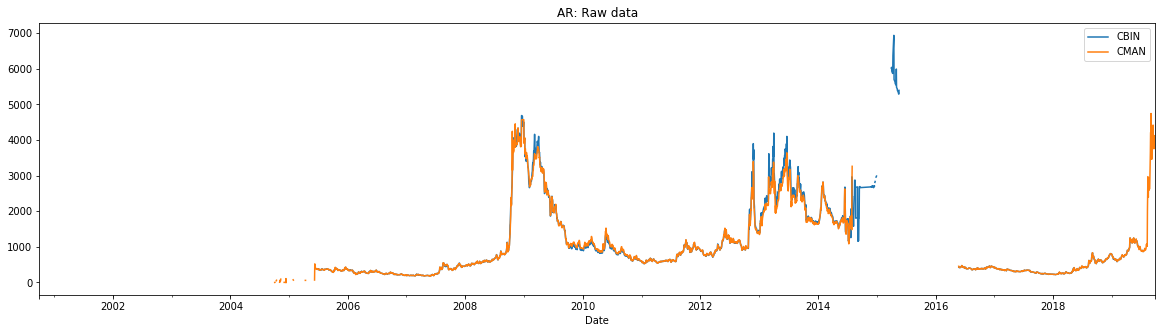

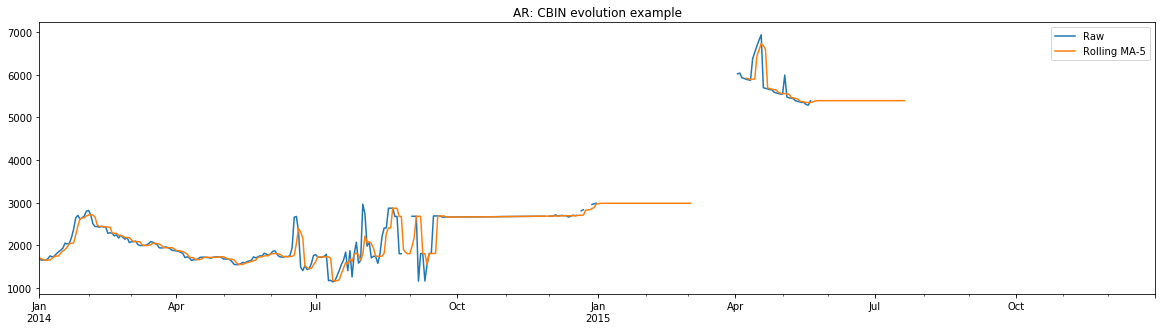

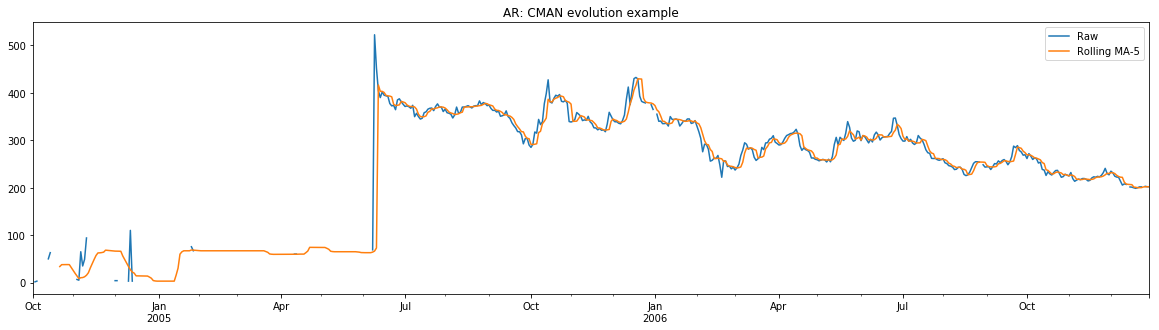

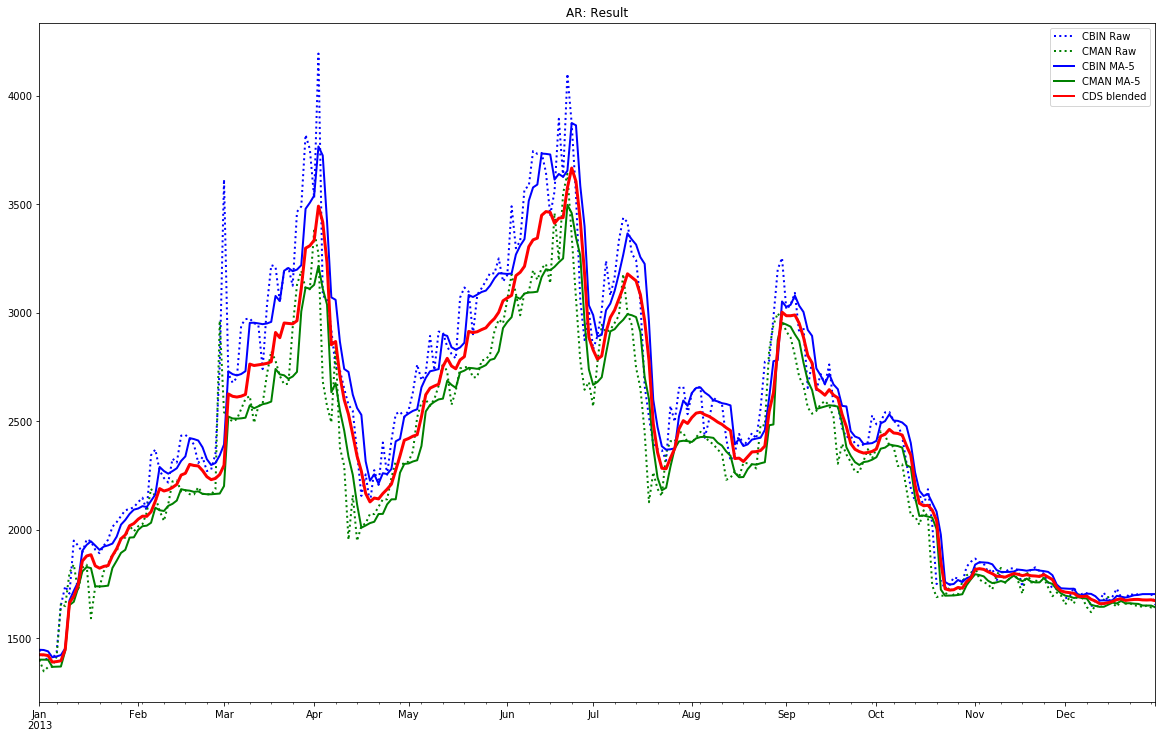

In [24]:
### PRESENTATION EXAMPLE

str_country = 'AR'
df_example_raw = df_cds_raw.loc[(All, str_country, All), ['CBIN', 'CMAN']].droplevel([1, 2])
df_example_ffill = df_cds_ffill.loc[(All, str_country, All), ['CBIN', 'CMAN']].droplevel([1, 2])
df_example_smooth = df_cds_smooth.loc[(All, str_country, All), ['CBIN', 'CMAN']].droplevel([1, 2])
df_example_bfill = df_cds_bfill.loc[(All, str_country, All), ['CBIN_backfill', 'CMAN_backfill']].droplevel([1, 2])
df_example_bfill.columns = ['CBIN', 'CMAN']
df_example_ma = df_cds_ma.loc[(All, str_country, All), ['CBIN', 'CMAN']].droplevel([1, 2])
df_example_ma.columns = ['CBIN MA-5', 'CMAN MA-5']
df_example_cbin = pd.concat([df_example_raw['CBIN'], df_example_ffill['CBIN'], df_example_smooth['CBIN'], df_example_bfill['CBIN'], df_example_ma['CBIN MA-5']], axis = 1)
df_example_cbin.columns = ['Raw', 'Forward filled', 'Smoothed', 'Back filled', 'Rolling MA-5']
df_example_cman = pd.concat([df_example_raw['CMAN'], df_example_ffill['CMAN'], df_example_smooth['CMAN'], df_example_bfill['CMAN'], df_example_ma['CMAN MA-5']], axis = 1)
df_example_cman.columns = ['Raw', 'Forward filled', 'Smoothed', 'Back filled', 'Rolling MA-5']
ser_example_res = ser_cds_res.loc[All, str_country, All].droplevel(1)
df_example_res = pd.concat([df_example_raw, df_example_ma, ser_example_res], axis = 1)
df_example_res.columns = ['CBIN Raw', 'CMAN Raw', 'CBIN MA-5', 'CMAN MA-5', 'CDS blended']
df_example_raw.plot(figsize = tup_plt_size, title = str_country + ': Raw data')
range_cbin = pd.date_range('2014-01-01', '2015-12-31', freq = 'B')
df_example_cbin.loc[range_cbin, ['Raw', 'Rolling MA-5']].plot(figsize = tup_plt_size, title = str_country + ': CBIN evolution example', style = '-', markersize = 4)
range_cman = pd.date_range('2004-10-01', '2006-12-31', freq = 'B')
df_example_cman.loc[range_cman, ['Raw', 'Rolling MA-5']].plot(figsize = tup_plt_size, title = str_country + ': CMAN evolution example', style = '-', markersize = 6)
range_res = pd.date_range('2013-01-01', '2013-12-31', freq = 'B')
plt_res = df_example_res.loc[range_res].plot(figsize = (20, 12.5), title = str_country + ': Result', style = ['b:', 'g:', 'b-', 'g-', 'r-'], markersize = 4, linewidth = 2)
plt.setp(plt_res.lines[-1], linewidth = 3)

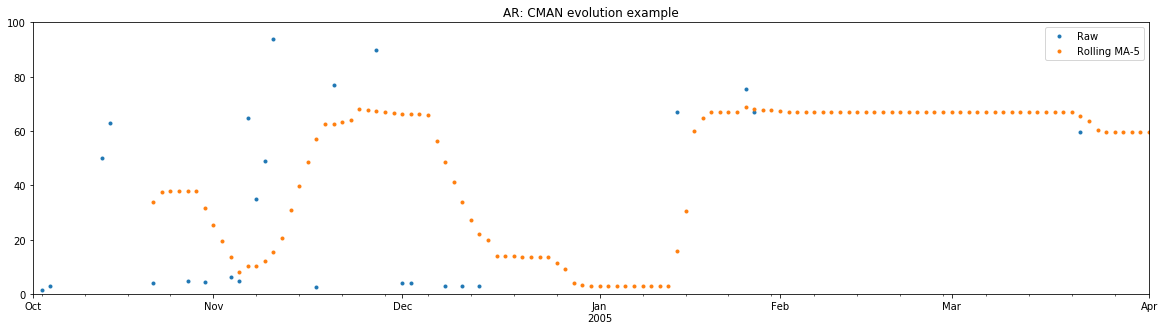

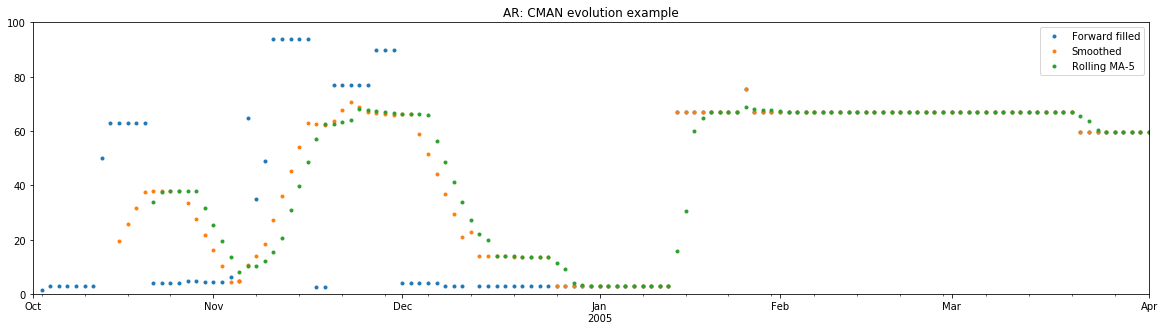

In [92]:
### PRESENTATION EXAMPLE

range_cman_detailed = pd.date_range('2004-10-01', '2005-04-01', freq = 'B')

df_example_cman.loc[range_cman_detailed, ['Raw', 'Rolling MA-5']].plot(figsize = (20, 5), title = str_country + ': CMAN evolution example', 
                                                       style = '.', markersize = 6, ylim = [0, 100])

df_example_cman.loc[range_cman_detailed, ['Forward filled', 'Smoothed', 'Rolling MA-5']].plot(figsize = (20, 5), title = str_country + ': CMAN evolution example', 
                                                         style = '.', markersize = 6, ylim = [0, 100])



In [ ]:
### PRESENTATION X_SECTIONAL TABLES
list_region_filter = [['DM', 'EM', 'FM'], 'DM', 'EM', 'FM']
list_region_name = ['ISON', 'DM', 'EM', 'FM']
list_bin = list(range(0, 1000, 50)) + list(range(1000, 6000, 1000))
for (iter_region_filter, iter_region_name) in zip(list_region_filter, list_region_name):
#    print(f'{iter_region_filter} / {iter_region_name}')
    ser_iter_region = ser_cds_res.loc[All, All, iter_region_filter]
    ### Cross-sectional mean measures calculating:
    print(iter_region_name, ':', 'cross-sectional mean :', ser_iter_region.groupby('Date').mean().mean())
    print(iter_region_name, ':', 'cross-sectional median :', ser_iter_region.groupby('Date').median().mean())
    print(iter_region_name, ':', 'cross-sectional std :', ser_iter_region.groupby('Date').std().mean())    
    print(iter_region_name, ':', 'cross-sectional 90-10 IQR :', 
          (ser_iter_region.groupby('Date').quantile(0.90) - ser_iter_region.groupby('Date').quantile(0.10)).mean())
    ### CDS bin distribution drawing:
    (ser_iter_region.groupby(pd.cut(ser_iter_region, bins = list_bin + [ser_iter_region.max()])).count() / ser_iter_region.count()).\
    plot(figsize = tup_plt_size, kind = 'bar', title = (iter_region_name + ' - distribution'))
    plt.show() 
    ### Timeline for filtered countries plotting:
    dict_color = {'boxes': 'DarkBlue', 'medians': 'Green', 'whiskers': 'Blue', 'caps': 'Black'}
    ser_iter_region.unstack('Country').reindex(ser_iter_region.unstack('Country').median().sort_values().index, axis = 1).\
    plot.box(figsize = tup_plt_size, title = (iter_region_name + ' - by country box plot (whiskers for 10% & 90% percentiles with no outliers)'),
             color = dict_color, sym = 'r+', whis = [10, 90], showfliers = False)
    ser_iter_region.unstack('Country').reindex(ser_iter_region.unstack('Country').median().sort_values().index, axis = 1).\
    plot.box(figsize = tup_plt_size, title = (iter_region_name + ' - by country box plot (whiskers for 1% & 99% percentiles with outliers)'),
             color = dict_color, sym = 'r+', whis = [1, 99], showfliers = True)
    plt.show()  

In [ ]:
### TEMP
